# Task 3 - Time Series Forecasting


## Approaches

The prediction task using the time-series of the assignment can be solved in two ways.

1. **One-Step Ahead**: Take in the input matching the window length, predict the next value, verify the predicted value with the target value, then put the target value into the window. So essentially, predict one step ahead for a specified number of times.

2. **Multi-Step Ahead**: Instead of using the correct target value in the timeseries, the predicted value is put in the window, thus making the prediction a number of steps ahead. There are [4 possible strategies for the multi-step ahead forecasting](https://machinelearningmastery.com/multi-step-time-series-forecasting/). We are using the recursive strategy in this solution.


These are quite different machine learning tasks, applicable to different scenarios. The one step ahead forecast may be useful for Real-Time scenarios. The multiple step ahead forecast may be used for regression analysis. 


---

## Imports

In [1]:
import os
import copy
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
data_dir = os.getcwd() + '/Data/'

# Parse dates and set TIMESTAMP as index. Will be useful later
traindata = pd.read_csv(data_dir + 'TrainData.csv', parse_dates=['TIMESTAMP'], index_col=0)
traindata = traindata.filter(['POWER'], axis=1)

solution = pd.read_csv(data_dir + 'Solution.csv', parse_dates=['TIMESTAMP'], index_col=0)
solution = solution.filter(['POWER'], axis=1)

## Globals

In [5]:
WINDOW_LENGTH = 6
FORECAST_LENGTH = 6

In [6]:
print(len(solution) % WINDOW_LENGTH)
print(len(solution) % FORECAST_LENGTH)

0
0


---

## Data processing

Solving the time series forecasting may be done via regression. This approach is sometimes called reduction, as we reduce the forecasting task to the simpler but related task of tabular regression. This allows to apply any regression algorithm to the forecasting problem.

In order to train the models with the timeseries data, we are required to prepare to the data into the required tabular format. The function below formats the training series into windows of fixed length and stacking them on top of each other. The target variable consists of the subsequent observation for each window.

[Source](https://github.com/sktime/sktime-tutorial-pydata-amsterdam-2020/blob/main/notebooks/02_forecasting.ipynb)

In [7]:
def format_time_series_data(data, window_length):
    _data = copy.deepcopy(data)
    _x, _y = _data[:-1], np.roll(_data, -window_length)[:-window_length]
    _x = np.reshape(_x, (-1, 1))
    
    tmp = np.roll(_x, -1)
    for i in range(1, window_length):
        _x = np.concatenate((_x[:-1], tmp[:-1]), 1)
        tmp = np.roll(tmp, -1)[:-1]
        
    return _x, _y.flatten()

In [8]:
x, y = format_time_series_data(traindata.values, WINDOW_LENGTH)
print('Shape of training inputs, training target:', x.shape, y.shape)

Shape of training inputs, training target: (16074, 6) (16074,)


We can apply this function to the testdata as well. However, in order to have our model predict the first initial values of the set, where the size of these of initial values correspond to window length we need to prepend the training data to the solution data.

In [9]:
to_solution = traindata.tail(WINDOW_LENGTH)
testdata = to_solution.append(solution)
x_test, y_test = format_time_series_data(testdata.values, WINDOW_LENGTH)
print('Shape of testing inputs, testing target:', x_test.shape, y_test.shape)

Shape of testing inputs, testing target: (720, 6) (720,)


In [10]:
# Explained later
def format_time_series_data_3dim(data, window_length, forecast_length=1):
    _data = copy.deepcopy(data)
    _x = _data[:-1]
    loop = 0

    if forecast_length > 1:
        loop = window_length + forecast_length
    else:
        loop = window_length
        _y = np.roll(_data, -window_length)[window_length:]
    
    # input sequence
    _x = np.reshape(_x, (-1, 1))
    tmp_x = np.roll(_x, -1)
    for i in range(1, loop):
        _x = np.concatenate((_x[:-1], tmp_x[:-1]), 1)
        tmp_x = np.roll(tmp_x, -1)[:-1]

    _x = np.reshape(_x, (_x.shape[0], _x.shape[1], 1))
    
    if forecast_length > 1:
        _x, _y = _x[:, :window_length], _x[:, window_length:]
    
    return _x, _y

---

## One-Step Ahead

### Imports


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [12]:
models = { 
    'LR'  : LinearRegression(), 
    'SVR' : SVR(), 
    'MLP' : MLPRegressor(solver='lbfgs', activation='relu', hidden_layer_sizes=[50, 50], max_iter=500)
}

### Training

In [13]:
for m in models.values():
    m.fit(x, y)

### Forecasts

In [14]:
onestep_results = { 'LR': [], 'SVR': [], 'MLP': [] }

for k in models:
    onestep_results[k] = models[k].predict(x_test)

### Results

In [15]:
rmse = { 'LR': 0.0, 'SVR': 0.0, 'MLP': 0.0 }

for k in models:
    rmse[k] = np.sqrt(mean_squared_error(y_true=y_test, y_pred=onestep_results[k]))
    print(f'RMSE {k}:\t{rmse[k]}')

RMSE LR:	0.12324204527949675
RMSE SVR:	0.12309993463165761
RMSE MLP:	0.12296438325218861


#### Plots

In [16]:
#fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(15,15), sharex=True)
#fig.suptitle('Results from One-Step Ahead forecasts')

#sns.lineplot(ax=ax0, x=solution.index, y=y_test, label='Solution')
#sns.lineplot(ax=ax0, x=solution.index, y=onestep_results['LR'], label='Linear Regression')

#sns.lineplot(ax=ax1, x=solution.index, y=y_test, label='Solution')
#sns.lineplot(ax=ax1, x=solution.index, y=onestep_results['SVR'], label='Support Vector Regression')

#sns.lineplot(ax=ax2, x=solution.index, y=y_test, label='Solution')
#sns.lineplot(ax=ax2, x=solution.index, y=onestep_results['MLP'], label='MLP Regression')

#ax0.legend(loc='lower right')
#ax1.legend(loc='lower right')
#ax2.legend(loc='lower right')

#plt.setp(ax0, ylabel='Normalized Power')
#plt.setp(ax1, ylabel='Normalized Power')
#plt.setp(ax2, ylabel='Normalized Power')

#fig.tight_layout()

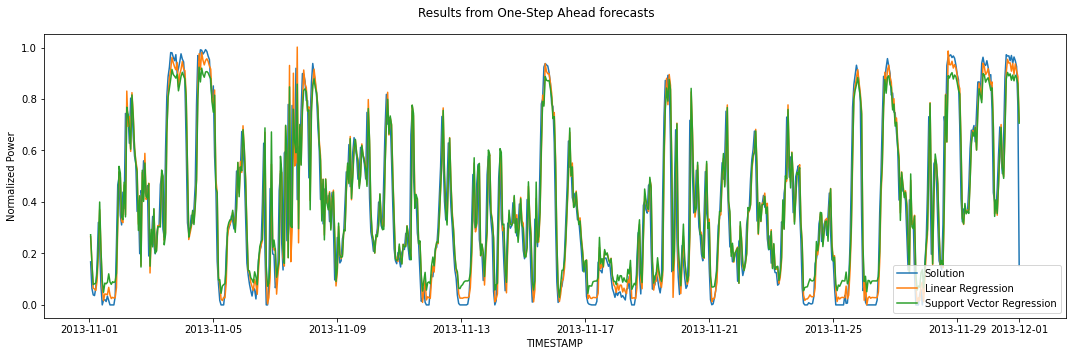

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Results from One-Step Ahead forecasts')

sns.lineplot(ax=ax, x=solution.index, y=solution['POWER'].values, label='Solution')

sns.lineplot(ax=ax, x=solution.index, y=onestep_results['LR'], label='Linear Regression')
sns.lineplot(ax=ax, x=solution.index, y=onestep_results['SVR'], label='Support Vector Regression')
#sns.lineplot(ax=ax, x=solution.index, y=onestep_results['MLP'], label='MLP Regression')

ax.legend(loc='lower right')
plt.setp(ax, ylabel='Normalized Power')


fig.tight_layout()

---

## Multi-Step Ahead

For making Multi-Step ahead forecasts we can use the models we have already fitted to one step ahead forecasts. We are required to only modify the prediction itself. Instead of updating the sliding window with the correct value, we update it with the predicted value. The function below simplifies this. 

In [18]:
def make_multistep_forecast_sk(model, data, forecast_length):
    forecasts = []
    for i in range(0, len(data)):
        last_w = np.asanyarray([data[i]])
        p = []
        last_p = model.predict(last_w)[0]
        for i in range(forecast_length):
            p.append(last_p)
            last_w[0] = np.roll(last_w[0], -1)
            last_w[0, (len(last_w[0]) - 1)] = last_p

            last_p = model.predict(last_w)[0]
        forecasts.append(np.asanyarray(p))
    
    forecasts = np.asanyarray(forecasts)
    
    #return np.reshape(forecasts, (forecasts.shape[0]*forecasts.shape[1]))
    return forecasts

### Forecasts

In [19]:
multistep_results = { 'LR': [], 'SVR': [], 'MLP': [] }

for k in models:
    multistep_results[k] = make_multistep_forecast_sk(models[k], x_test, FORECAST_LENGTH)

### Results

The shape of the forecast depends on the window length and forecast length. This can be verified by checking the shape of the outputs.

Therefore when calculating the RMSE, we can calculate the RMSE for all the forecasts. However when  drawing plots it is a bit more tricky, as each forecast has multiple values and mathing the shapes of data is tricky. 

Therefore, we will consider the worst case scenario, which is the last predicted step in each forecast. For completeness, we will also consider the RMSE of the desired step of each function. We transpose the dat arrays so that all the forecasts steps are contained a single array. So, for instance we can than extract the last value of each forecast.

In [20]:
# Check shape
for k in multistep_results:
    print(f'Model: {k}\tShape {multistep_results[k].shape}')

Model: LR	Shape (720, 6)
Model: SVR	Shape (720, 6)
Model: MLP	Shape (720, 6)


#### RMSE - Regular

In [21]:
# Refresh testdata just in case
to_solution = traindata.tail(WINDOW_LENGTH+FORECAST_LENGTH)
validation = to_solution.append(solution)

In [22]:
# x, y = format_time_series_data(testdata['POWER'].values, WINDOW_LENGTH)

x, y = format_time_series_data_3dim(validation['POWER'].values, WINDOW_LENGTH, FORECAST_LENGTH)
y = np.reshape(y, (y.shape[0], y.shape[1]))

multistep_rmse = rmse = { 'LR': 0.0, 'SVR': 0.0, 'MLP': 0.0 }

for k in multistep_results:
    multistep_rmse[k] = np.sqrt(mean_squared_error(y_true=y, y_pred=multistep_results[k]))
    print(f'{k}\tRMSE: {multistep_rmse[k]}')

LR	RMSE: 0.22945534392526457
SVR	RMSE: 0.2485551374888492
MLP	RMSE: 0.23593895210297963


#### RMSE - Last step of forecast

In [23]:
index = FORECAST_LENGTH - 1 # last forecasting time step
multistep_laststep = { 'LR': [], 'SVR': [], 'MLP': [] }  
multistep_rmse_laststep = { 'LR': 0.0, 'SVR': 0.0, 'MLP': 0.0 }


for k in multistep_results:
    multistep_laststep[k] = np.transpose(multistep_results[k])[index]
    multistep_rmse_laststep[k] = np.sqrt(mean_squared_error(y_true=solution['POWER'].values, y_pred=multistep_laststep[k]))
    print(f'Multistep RMSE {k}:\t{multistep_rmse_laststep[k]}')


Multistep RMSE LR:	0.15079647269959104
Multistep RMSE SVR:	0.20432667660485138
Multistep RMSE MLP:	0.16460576986500938


#### Plots

In [24]:
#fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(15,15), sharex=True)
#fig.suptitle('Results from Multi-Step Ahead forecasts')

#sns.lineplot(ax=ax0, x=solution.index, y=solution['POWER'].values, label='Solution')
#sns.lineplot(ax=ax0, x=solution.index, y=multistep_laststep['LR'], label='Linear Regression')

#sns.lineplot(ax=ax1, x=solution.index, y=solution.values.flatten(), label='Solution')
#sns.lineplot(ax=ax1, x=solution.index, y=multistep_laststep['SVR'], label='Support Vector Regression')

#sns.lineplot(ax=ax2, x=solution.index, y=solution.values.flatten(), label='Solution')
#sns.lineplot(ax=ax2, x=solution.index, y=multistep_laststep['MLP'], label='MLP Regression')
#sns.lineplot(ax=ax2, x=solution.index, y=res, label='MLP Regression2')


#ax0.legend(loc='lower right')
#ax1.legend(loc='lower right')
#ax2.legend(loc='lower right')

#plt.setp(ax0, ylabel='Normalized Power')
#plt.setp(ax1, ylabel='Normalized Power')
#plt.setp(ax2, ylabel='Normalized Power')

#fig.tight_layout()

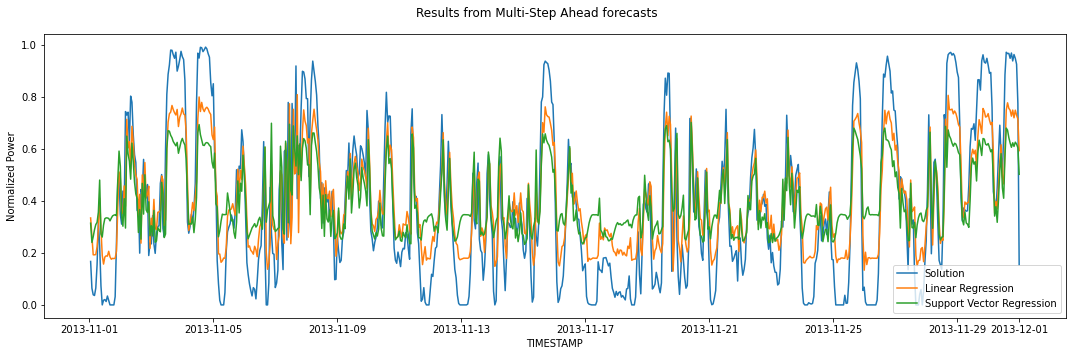

In [25]:
#Without MLP
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Results from Multi-Step Ahead forecasts')

sns.lineplot(ax=ax, x=solution.index, y=solution['POWER'].values, label='Solution')
sns.lineplot(ax=ax, x=solution.index, y=multistep_laststep['LR'], label='Linear Regression')
sns.lineplot(ax=ax, x=solution.index, y=multistep_laststep['SVR'], label='Support Vector Regression')

ax.legend(loc='lower right')
plt.setp(ax, ylabel='Normalized Power')

fig.tight_layout()

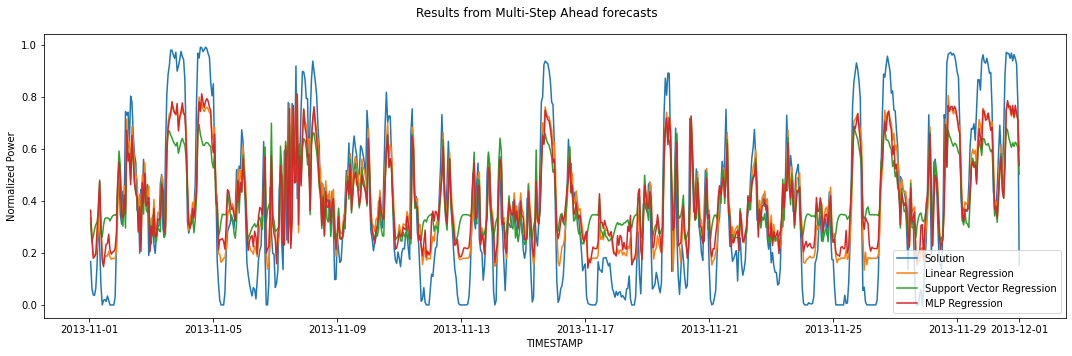

In [26]:
# With MLP
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Results from Multi-Step Ahead forecasts')

sns.lineplot(ax=ax, x=solution.index, y=solution['POWER'].values, label='Solution')
sns.lineplot(ax=ax, x=solution.index, y=multistep_laststep['LR'], label='Linear Regression')
sns.lineplot(ax=ax, x=solution.index, y=multistep_laststep['SVR'], label='Support Vector Regression')
sns.lineplot(ax=ax, x=solution.index, y=multistep_laststep['MLP'], label='MLP Regression')

ax.legend(loc='lower right')
plt.setp(ax, ylabel='Normalized Power')

fig.tight_layout()

---

# RNN with Keras

In this section we will go implement time series forecasting with Recurrent NN by using Keras library.

This section will be split into two parts: the first where we evaluate models with One-Step Ahead forecast while the second part will evaluate the Multi-Step Ahead Forecasts. 

### Imports

In [27]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model, load_model
import copy

### Globals

In [28]:
N_BATCH = 24 # used for making the compiling fo quicker
NEURONS = 20
EPOCHS = 10

## Data Processing 

The RNN require a very specific structure of data in order to function properly. That structure is `[samples, time steps, features]`. For this task we work with only 1 feature, which is therefore hardcoded below. The samples refer to the number of observations, while the time steps refer to the window length.

For these two networks we are feeding them data in the same fashion in order to provide good comparisons. Here we extend the `format_time_series_data()` function provided earlier. We have therefore devised a function that will process this data in the desired format. This function can be used for both one-step and multi-step ahead solutions. In the case of one-step ahead the forecast_length need not be specified as it will use the default value of 1.

In [29]:
def format_time_series_data_3dim(data, window_length, forecast_length=1):
    _data = copy.deepcopy(data)
    _x = _data[:-1]
    loop = 0

    if forecast_length > 1:
        loop = window_length + forecast_length
    else:
        loop = window_length
        _y = np.roll(_data, -window_length)[window_length:]
    
    # input sequence
    _x = np.reshape(_x, (-1, 1))
    tmp_x = np.roll(_x, -1)
    for i in range(1, loop):
        _x = np.concatenate((_x[:-1], tmp_x[:-1]), 1)
        tmp_x = np.roll(tmp_x, -1)[:-1]

    _x = np.reshape(_x, (_x.shape[0], _x.shape[1], 1))
    
    if forecast_length > 1:
        _x, _y = _x[:, :window_length], _x[:, window_length:]
    
    return _x, _y

### RNN Design

Similarly to the RNN, we have made a function that is applicable for both creating a one-step and multi-step ahead forecast. The dropouts and recurrent dropout is configured here to 20% as in the previous DNN. 

In [30]:
def create_rnn(n_neurons, window_length, forecast_length=1, dropout=0.2, r_dropout=0.2, n_batch=1):
    _rnn = Sequential([
        LSTM(n_neurons, input_shape=(window_length, 1), dropout=dropout, 
             recurrent_dropout=r_dropout, activation='sigmoid'),
        Dense(forecast_length, activation='sigmoid')
    ])
    _rnn.compile(loss='mean_squared_error', optimizer='adam')
    return _rnn

In [31]:
onestep_rnn = create_rnn(NEURONS, WINDOW_LENGTH, n_batch=N_BATCH)
onestep_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


### Training

For training our models we apply the same procedure: first use the function to format the time series data. Furthermore, Keras allows for creating a validation set out of the training data. This validation set is run after every epoch and checks the error. We also keep a track of the training error but it's not as important as validation error since the training error is what adjusts the weights. Only when the validation error has come down to near the training error, we stop further training. Thus we must find the optimal number of epochs for the fitting.

Thus we split the training data further into training and validation sets. The validation set is set to the last 8% of the training set. The reason we do not shuffle these, is to avoid data leakage. 

In [32]:
def fit_onestep_rnn(model, data, window_length, validation_percentage=0.08, n_epoch=10, n_batch=1):
    _x, _y = format_time_series_data_3dim(data, window_length)
    lim = int(len(data)*validation_percentage)
    _x_valid, _y_valid = _x[-lim:], _y[-lim:]
    _x_train, _y_train = _x[:-lim], _y[:-lim]

    return model.fit(x=_x_train, y=_y_train, epochs=n_epoch, batch_size=n_batch, validation_data=(_x_valid, _y_valid))

In [33]:
# RNN Training
fit_rnn_res = fit_onestep_rnn(onestep_rnn, traindata['POWER'].values, WINDOW_LENGTH, n_batch=N_BATCH)

Epoch 1/10
617/617 [==============================] - 10s 12ms/step - loss: 0.1142 - val_loss: 0.1029
Epoch 2/10
617/617 [==============================] - 7s 11ms/step - loss: 0.0896 - val_loss: 0.0982
Epoch 3/10
617/617 [==============================] - 6s 10ms/step - loss: 0.0862 - val_loss: 0.0949
Epoch 4/10
617/617 [==============================] - 6s 10ms/step - loss: 0.0842 - val_loss: 0.0960
Epoch 5/10
617/617 [==============================] - 7s 11ms/step - loss: 0.0846 - val_loss: 0.0951
Epoch 6/10
617/617 [==============================] - 5s 8ms/step - loss: 0.0846 - val_loss: 0.0927
Epoch 7/10
617/617 [==============================] - 5s 8ms/step - loss: 0.0851 - val_loss: 0.0931
Epoch 8/10
617/617 [==============================] - 6s 10ms/step - loss: 0.0847 - val_loss: 0.0956
Epoch 9/10
617/617 [==============================] - 6s 9ms/step - loss: 0.0857 - val_loss: 0.0940
Epoch 10/10
617/617 [==============================] - 5s 9ms/step - loss: 0.0832 - val_loss:

### Forecast 

As with training, the forecasting procedure is the same. Therefore we use a function that makes the prediction in the same manner.

In [34]:
def make_onestep_forecast_rnn(model, data, window_length, n_batch=1):
    _x, _ = format_time_series_data_3dim(data, window_length)
    #_x = np.reshape(_x, (_x.shape[0], _x.shape[1], 1))

    return model.predict(_x, batch_size=n_batch)

In [35]:
# Refresh testdata just in case
to_solution = traindata.tail(WINDOW_LENGTH)
testdata = to_solution.append(solution)

In [36]:
# RNN Forecast
onestep_rnn_forecast = make_onestep_forecast_rnn(onestep_rnn, testdata['POWER'].values, WINDOW_LENGTH, n_batch=24)

### Results

In [37]:
print(f'RNN Forecast shape:\t\t{onestep_rnn_forecast.shape}')
onestep_rnn_forecast = onestep_rnn_forecast.flatten()
print(f'Flattened RNN Forecast shape:\t\t{onestep_rnn_forecast.shape}')

RNN Forecast shape:		(720, 1)
Flattened RNN Forecast shape:		(720,)


However, we can just reshape the data in order to calculate the RMSE and plot them nicely.

#### RMSE

In [38]:
rmse_rnn = np.sqrt(mean_squared_error(y_true=solution['POWER'].values, y_pred=onestep_rnn_forecast))
print(f'RMSE RNN: {rmse_rnn}')

RMSE RNN: 0.19102531103611517


#### Plots

[Text(0, 0.5, 'Normalized Power')]

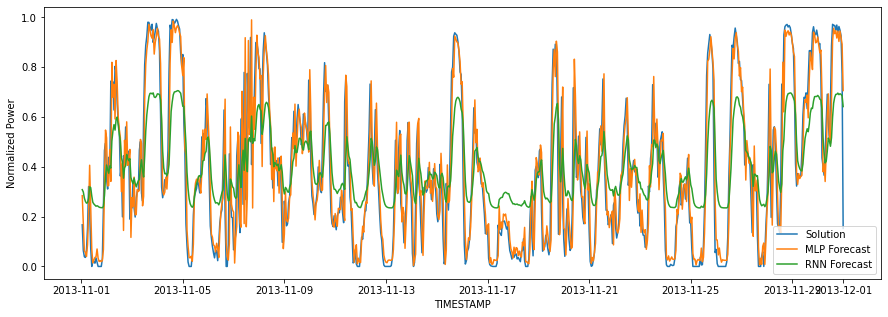

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(ax=ax, x=solution.index, y=solution['POWER'], label='Solution')
sns.lineplot(ax=ax, x=solution.index, y=onestep_results['MLP'], label='MLP Forecast')
sns.lineplot(ax=ax, x=solution.index, y=onestep_rnn_forecast, label='RNN Forecast')
plt.setp(ax, ylabel='Normalized Power')


---

## Multi-Step Ahead Forecast


### RNN Design

LSTM is designed for such forecasts, so we can just use the same function as previously.

In [40]:
multistep_rnn = create_rnn(NEURONS, WINDOW_LENGTH, FORECAST_LENGTH, n_batch=N_BATCH)
multistep_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 1,886
Trainable params: 1,886
Non-trainable params: 0
_________________________________________________________________


### Training

Training the multistep model requires the recursive approach described previously. The model state is reset for The function below works for both models.

In [41]:
def fit_multistep_rnn(model, data, window_length, forecast_length, n_epoch=10, n_batch=1):
    _x, _y = format_time_series_data_3dim(data, window_length, forecast_length)
    #_x = np.reshape(_x, (_x.shape[0], _x.shape[1], 1))

    #print(_x.shape)
    #print(_y.shape)
    for i in range(n_epoch):
        model.fit(_x, _y, epochs=1, batch_size=n_batch, shuffle=False)
        model.reset_states()

In [42]:
# RNN Training
fit_multistep_rnn(multistep_rnn, traindata['POWER'].values, WINDOW_LENGTH, FORECAST_LENGTH, EPOCHS, n_batch=24)

670/670 [==============================] - 6s 9ms/step - loss: 0.0568


### Forecast 

As previously, the forecasting procedure for both models is the same. Here the recursive approach is used. For every 'round of forecasts' (/loop) the forecasts are stroed in the list that is returned. The shape of the list is `(datalength - (window_length + forecast_length), forecast_length)` Therefore we use a function that makes the prediction in the same manner.

In [43]:
# Refresh testdata just in case
to_solution = traindata.tail(WINDOW_LENGTH+FORECAST_LENGTH)
testdata = to_solution.append(solution)

In [44]:
def make_multistep_forecast(model, data, window_length, forecast_length, n_batch=1):
    forecasts = []
    _x, _ = format_time_series_data_3dim(data, window_length, forecast_length)
    #_x = np.reshape(_x, (_x.shape[0], _x.shape[1], 1))

    for i in range(len(_x)):
        _xt = _x[i,:]
        _xt = np.reshape(_xt, (_xt.shape[1], len(_xt), 1))
        _curr_fc = model.predict(_xt, batch_size=n_batch)
        forecasts.append([_f for _f in _curr_fc[0, :]])
    
    return np.asanyarray(forecasts)

In [45]:
# RNN Forecast
multistep_rnn_forecast = make_multistep_forecast(multistep_rnn, testdata['POWER'].values, 
                                                 WINDOW_LENGTH, FORECAST_LENGTH)

### Results 

The shape of the forecast depends on the window length and forecast length. This can be verified by checking the shape of the outputs.

In [46]:
print(f'RNN Forecast shape: {multistep_rnn_forecast.shape}')

RNN Forecast shape: (720, 6)


Therefore when calculating the RMSE, we can calculate the RMSE for all the forecasts. However when  drawing plots it is a bit more tricky, as each forecast has multiple values and mathing the shapes of data is tricky. 

Therefore, we will consider the worst case scenario, which is the last predicted step in each forecast. For completeness, we will also consider the RMSE of the desired step of each function. We transpose the dat arrays so that all the forecasts steps are contained a single array. So, for instance we can than extract the last value of each forecast.

#### RMSE - Regular

In [47]:
x, y = format_time_series_data_3dim(testdata['POWER'].values, WINDOW_LENGTH, FORECAST_LENGTH)

y = np.reshape(y, (y.shape[0], y.shape[1]))
rmse_multi_rnn_reg = np.sqrt(mean_squared_error(y_true=y, y_pred=multistep_rnn_forecast))

print(f'RMSE RNN: {rmse_multi_rnn_reg}')
print(f'RMSE MLP: {rmse["MLP"]}')

RMSE RNN: 0.23978629288859346
RMSE MLP: 0.23593895210297963


#### RMSE - Last step of the forecast

In [48]:
index = FORECAST_LENGTH - 1 # last forecasting time step
multistep_rnn_forecast_step = np.transpose(multistep_rnn_forecast)[index]
rmse_multi_rnn_ls = np.sqrt(mean_squared_error(y_true=solution['POWER'].values, y_pred=multistep_rnn_forecast_step))
print(f'Multistep last step RMSE RNN:\t{rmse_multi_rnn_ls}')
print(f'Multistep last step RMSE MLP:\t{multistep_rmse_laststep["MLP"]}')

Multistep last step RMSE RNN:	0.30301032966346747
Multistep last step RMSE MLP:	0.16460576986500938


#### Plots

[Text(0, 0.5, 'Normalized Power')]

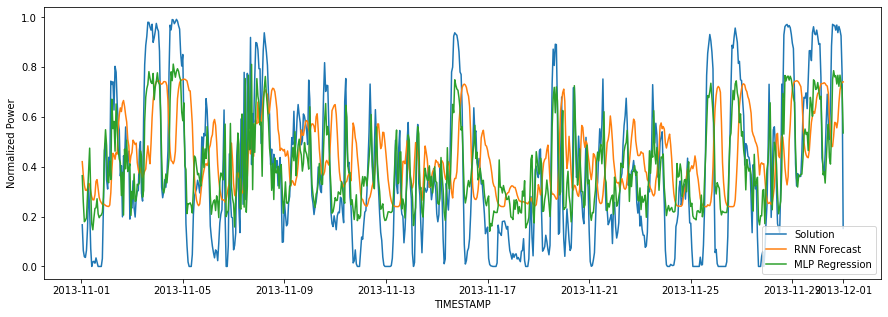

In [49]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(ax=ax, x=solution.index, y=solution['POWER'].values, label='Solution')
sns.lineplot(ax=ax, x=solution.index, y=multistep_rnn_forecast_step, label='RNN Forecast')
sns.lineplot(ax=ax, x=solution.index, y=multistep_laststep['MLP'], label='MLP Regression')

plt.setp(ax, ylabel='Normalized Power')

In [50]:
solved = solution.drop(['POWER'], axis=1)
solved["FORECAST"] = onestep_results['LR']
solved.to_csv(data_dir+"ForecastTemplate3-OSA-LR.csv")

solved = solution.drop(['POWER'], axis=1)
solved["FORECAST"] = onestep_results['SVR']
solved.to_csv(data_dir+"ForecastTemplate3-OSA-SVR.csv")

solved = solution.drop(['POWER'], axis=1)
solved["FORECAST"] = onestep_results['MLP']
solved.to_csv(data_dir+"ForecastTemplate3-OSA-MLP.csv")


solved = solution.drop(['POWER'], axis=1)
solved["FORECAST"] = multistep_laststep['LR']
solved.to_csv(data_dir+"ForecastTemplate3-MSA-LR.csv")

solved = solution.drop(['POWER'], axis=1)
solved["FORECAST"] = multistep_laststep['SVR']
solved.to_csv(data_dir+"ForecastTemplate3-MSA-SVR.csv")

solved = solution.drop(['POWER'], axis=1)
solved["FORECAST"] = multistep_laststep['MLP']
solved.to_csv(data_dir+"ForecastTemplate3-MSA-MLP.csv")

solved = solution.drop(['POWER'], axis=1)
solved["FORECAST"] = onestep_rnn_forecast
solved.to_csv(data_dir+"ForecastTemplate3-OSA-RNN.csv")

solved = solution.drop(['POWER'], axis=1)
solved["FORECAST"] = multistep_rnn_forecast_step
solved.to_csv(data_dir+"ForecastTemplate3-MSA-RNN.csv")